# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Построим модель для определения стоимости автомобиля.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Подготовка данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
343118,2016-03-31 13:56:22,1200,small,2000,manual,75,clio,150000,6,petrol,renault,no,2016-03-31 00:00:00,0,14612,2016-04-06 06:44:54
320764,2016-03-08 15:53:06,2100,NaN,2018,manual,0,other,150000,6,gasoline,opel,no,2016-03-08 00:00:00,0,66333,2016-03-08 15:53:06
323664,2016-03-25 12:54:42,1,NaN,2000,manual,0,carisma,150000,8,NaN,mitsubishi,yes,2016-03-25 00:00:00,0,19395,2016-04-06 14:44:49


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.columns 

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [6]:
df = df.drop(columns=['DateCrawled', 
                      'DateCreated', 
                      'LastSeen', 
                      'NumberOfPictures', 
                      'PostalCode', 
                      'RegistrationMonth'])

Удлаим ненужные для исследования столбцы

In [7]:
df.shape

(354369, 10)

In [8]:
df.isna().sum() 

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Проверим, сколько пропусков есть в датасете

In [9]:
df = df.dropna(subset=['Model'])

In [10]:
df = df.dropna(subset=['FuelType'])

In [11]:
df = df.dropna(subset=['Gearbox'])

In [12]:
df['VehicleType'] = df['VehicleType'].dropna()

In [13]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [14]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Удалим все пропуски и провери правильность использованного метода

In [15]:
df = df.rename(columns={'Price': 'price', 
                        'VehicleType': 'vehicle_type', 
                        'RegistrationYear': 'registration_year', 
                        'Gearbox': 'gearbox', 
                        'Power': 'power', 
                        'Model': 'model', 
                        'Kilometer': 'kilometer', 
                        'FuelType': 'fuel_type', 
                        'Brand': 'brand', 
                        'Repaired': 'repaired'})

Переименуем колонки

In [16]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [17]:
warnings.filterwarnings('ignore')

def remove(df, col):
    q1 = df[col].quantile(0.25) 
    q3 = df[col].quantile(0.75) 
    iqr = q3 - q1 

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    filtered_df = df[(df[col] >= lower) & (df[col] <= upper)]

    return filtered_df

df = remove(df, 'price')
df = remove(df, 'registration_year')
df = remove(df, 'kilometer')
df = remove(df, 'power')

<AxesSubplot:ylabel='Frequency'>

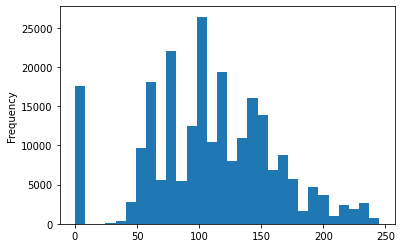

In [18]:
df['power'].plot(kind='hist', bins=30)

In [19]:
df = df[df['power'] > 10]

<AxesSubplot:ylabel='Frequency'>

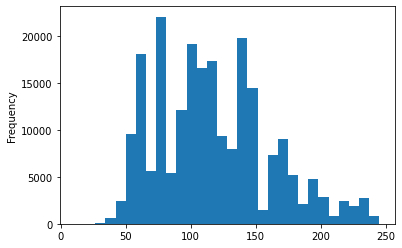

In [20]:
df['power'].plot(kind='hist', bins=30)

In [21]:
df = df[df['registration_year'] < 2016]

In [22]:
df['registration_year'].max() 

2015

Удалим выбросы в оставшихся колонках с количественными данными

In [23]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer
price,1.000000,0.635437,0.538475,-0.231987
registration_year,0.635437,1.000000,0.221151,-0.253510
power,0.538475,0.221151,1.000000,0.102690
kilometer,-0.231987,-0.253510,0.102690,1.000000


Матрица корреляций показывает, что тема мультиколлинеарности не относится к текущему исследованию потому что нет сильных линейных связей

## Обучение моделей

In [24]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

Выделим категориальные признаки

In [27]:
features = df.drop(columns='price')
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.2, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
                                        features_test, target_test, test_size=0.5, random_state=12345)

features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [34]:
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])

In [64]:
LR = LinearRegression()

CPU times: user 16 µs, sys: 5 µs, total: 21 µs
Wall time: 24.3 µs


In [65]:
%%time

LR.fit(features_train_ohe, target_train)

CPU times: user 11.1 s, sys: 18.9 s, total: 30 s
Wall time: 30.1 s


LinearRegression()

In [ ]:
predictions_lr = LR.predict(features_train_ohe) 

Оценим модель линейной регрессии

In [41]:
mse_lr = np.sqrt(mean_squared_error(target_train, predictions_lr))
print('RMSE:', mse_lr)

RMSE: 1783.9442123325782


In [43]:
%%time

print(cross_val_score(LR, features_train_ohe, target_train, cv=5, scoring='neg_root_mean_squared_error').mean())

-1787.3110313087461
CPU times: user 39.9 s, sys: 1min 8s, total: 1min 48s
Wall time: 1min 48s


In [44]:
features_cbr = df.drop(columns='price')
target_cbr = df['price']

features_trainc, features_testc, target_trainc, target_testc = train_test_split(
                                        features_cbr, target_cbr, test_size=0.2, random_state=12345)

In [25]:
%%time

model = CatBoostRegressor(random_state=12345, loss_function='RMSE', silent=True, cat_features=categ)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    #'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

grid_search.fit(features_trainc, target_trainc)

CPU times: user 36min 12s, sys: 10.5 s, total: 36min 22s
Wall time: 37min 24s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f68344158b0>,
             param_grid={'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

Найдем гиперпараметры через Grid Search CV для Cat Boost Regressor

In [33]:
print('Best hyperparams:', grid_search.best_params_) 
print('Best score:', np.sqrt(grid_search.best_score_))

Best hyperparams: {'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best score: nan


In [66]:
model = CatBoostRegressor(random_state=12345, loss_function='RMSE', silent=True,
                         iterations=300, l2_leaf_reg=1, learning_rate=0.1, cat_features=cat_features) 

In [68]:
%%time

model.fit(features_trainc, target_trainc)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CPU times: user 42.9 s, sys: 0 ns, total: 42.9 s
Wall time: 43.8 s


In [ ]:
pred = model.predict(features_valid)
metric = np.sqrt(mean_squared_error(target_valid, pred))

In [59]:
print('RMSE для CatBoostRegressor:', metric)

RMSE для CatBoostRegressor: 1355.818649897066


Выведем результаты

In [29]:
%%time

model = LGBMRegressor(random_state=12345, silent=True) 

param_dist = {
    'learning_rate': [0.01, 0.1], 
    'max_depth': [4, 6, 8], 
    'n_estimators': [60, 80, 100]
}

search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=5) 

CPU times: user 53 µs, sys: 0 ns, total: 53 µs
Wall time: 56.5 µs


In [30]:
%%time

search.fit(features_train, target_train)

CPU times: user 23min 50s, sys: 24 s, total: 24min 14s
Wall time: 24min 23s


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(random_state=12345, silent=True),
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [60, 80, 100]})

Воспользуемся Random Search для LGBM Regressor и получим: 

In [35]:
print('Best hyperparams:', search.best_params_) 
print('Best score:', np.sqrt(search.best_score_))

Best hyperparams: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}
Best score: 0.9092596227246815


In [69]:
model = LGBMRegressor(random_state=12345, n_estimators=100, max_depth=8, learning_rate=0.1) 

In [70]:
%%time

model.fit(features_train_ohe, target_train) 

CPU times: user 5min 37s, sys: 3.99 s, total: 5min 41s
Wall time: 5min 43s


LGBMRegressor(max_depth=8, random_state=12345)

In [71]:
predict = model.predict(features_valid_ohe) 

In [72]:
res = np.sqrt(mean_squared_error(target_valid, predict))

In [62]:
print('RMSE для LGBMRegressor:', res)

RMSE для LGBMRegressor: 1377.5882501662836


<div class="alert alert-block alert-success">
<b>V2 ✔️ Успешно исправлено</b>
</div>

## Анализ моделей

Таким образом, было проведено исследование трех моделей, были подобраны оптимальные гиперпараметры для каждой модели, кроме линейной регрессии. Лучше всего себя показала LGBM Regressor с гиперпараметрами: 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1, а RMSE составила 0.909. 

In [77]:
results = {
    'model': ['Linear Regression', 'CatBoostRegressor', 'LGBMRegressor'],
    'pred_time': ['1min 48s', '44.1 s', '4min 31s'],
    'fitting_time': ['30 s', '42.9 s', '5min 41s'],
    'RMSE': [1787.31, 1355.81, 1377.58]
}

results = pd.DataFrame(results)

results

,model,pred_time,fitting_time,RMSE
0,Linear Regression,1min 48s,30 s,1787.31
1,CatBoostRegressor,44.1 s,42.9 s,1355.81
2,LGBMRegressor,4min 31s,5min 41s,1377.58


Таким образом можно сказать, что исходя из полученных результатов модель CatBoost будет лучше других, потому что имеет наименьшую метрику RMSE, а также обучается и предсказывает результаты быстрее других рассмотренных моделей.

## Тестирование лучшей модели

In [79]:
model_final = CatBoostRegressor(random_state=12345, loss_function='RMSE', silent=True,
                         iterations=300, l2_leaf_reg=1, learning_rate=0.1, cat_features=cat_features) 

model_final.fit(features_trainc, target_trainc)

pred_final = model_final.predict(features_testc)

In [86]:
final_res = np.sqrt(mean_squared_error(target_testc, pred_final))

In [88]:
print('Лучшая модель с оптимальными гиперпараметрами на тестовой выборке имеет RMSE равное', final_res)

Лучшая модель с оптимальными гиперпараметрами на тестовой выборке имеет RMSE равное 1339.9255696267517
